## Atlas subsampling 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)

In [6]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

## Load dataset

In [7]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad')

## Make sample level anndata

In [265]:
sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=100)

In [266]:
## Make nhoods
milo.make_nhoods(adata, prop=0.01)
milo.count_nhoods(adata, sample_col='donor_id')
milopy.utils.add_covariate_to_nhoods_var(adata, ['sex', 'dataset_id', 'ethnicity', 'assay'])
sample_adata = adata.uns['nhood_adata'].T.copy()
sample_adata.layers['counts'] = sample_adata.X.copy()

## Normalize counts x donor
sc.pp.normalize_total(sample_adata, target_sum=10000)
sc.pp.log1p(sample_adata)

## Dim reduction
sc.pp.pca(sample_adata)

## Compute similarity between donors
n_pcs = 30
X_pca = sample_adata.obsm['X_pca']
sample_adata.obsp['distance_full'] = scipy.spatial.distance.cdist(X_pca[:,0:n_pcs], X_pca[:,0:n_pcs])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [267]:
sample_adata.write_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.donor_adata.h5ad')

In [152]:
sample_adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.donor_adata.h5ad')

### Compare controls 

In [176]:
## Define query donors
np.random.seed(41)
query_dataset = '10_1038_s41591_021_01329_2'
samples_design = np.random.choice((0, 1), sum(sample_adata.obs['dataset_id'] == query_dataset))
query_samples = sample_adata.obs_names[sample_adata.obs['dataset_id'] == query_dataset][samples_design == 1]


In [9]:
## Find set of closest samples to subset atlas
def find_ctrl_samples(
    sample_adata, 
    ctrl_samples_all,
    query_samples, 
    method = 'closest', ## one of closest, farthest, random
    n_ctrl: int = 15,
    random_seed = 42,
    n_pcs = 10
    ):
    '''
    Params:
    ------
    - sample_adata: sample-level anndata object
    - query_samples: list or collection of samples from query dataset
    - n_ctrl: number of control samples to pick
    '''
    
    # Get distances to query samples
    query_distances = scipy.spatial.distance.cdist(sample_adata[query_samples,:].obsm['X_pca'][:,0:n_pcs], sample_adata[ctrl_samples_all,:].obsm['X_pca'][:,0:n_pcs])
    
    # Get n_ctrl closest samples
    if method == 'closest':
        n_closest = 0
        k = 1
        ctrl_samples = np.array([])
        while n_closest < n_ctrl:
            closest_samples_k = np.argsort(query_distances, axis=1)[:,0:k]
            closest_samples = np.setdiff1d(np.unique(closest_samples_k), ctrl_samples)
            closest_dist = query_distances[:,closest_samples].min(axis=0).argsort()
            ctrl_samples = np.hstack([ctrl_samples, closest_samples[closest_dist][0:(n_ctrl - n_closest)]])
            n_closest = len(ctrl_samples)
            k +=1
        ctrl_samples = ctrl_samples_all[ctrl_samples.astype('int')]

    if method == 'farthest':
        n_closest = 0
        k = 1
        ctrl_samples = np.array([])
        while n_closest < n_ctrl:
            closest_samples_k = np.argsort(query_distances, axis=1)[:,-k:]
            closest_samples = np.setdiff1d(np.unique(closest_samples_k), ctrl_samples)
            closest_dist = query_distances[:,closest_samples].min(axis=0).argsort()
            ctrl_samples = np.hstack([ctrl_samples, closest_samples[closest_dist][0:(n_ctrl - n_closest)]])
            n_closest = len(ctrl_samples)
            k +=1
        ctrl_samples = ctrl_samples_all[ctrl_samples.astype('int')]

    if method == 'random':
        np.random.seed(random_seed)
        ctrl_samples = np.random.choice(ctrl_samples_all, n_ctrl, replace=False)

    return(ctrl_samples)
# ## Get ctrl samples closest to avg of query samples
# closest_samples = ctrl_samples[np.argsort(query_distances.mean(axis=0))[0:n_ctrl]]

In [178]:
## Matched control samples
matched_ctrl = sample_adata.obs_names[(sample_adata.obs['dataset_id'] == query_dataset) & (~sample_adata.obs_names.isin(query_samples))]
sample_adata.obs[f'matched_ctrl'] = sample_adata.obs_names.isin(matched_ctrl).astype('int')

ctrl_samples_all = sample_adata.obs_names[sample_adata.obs['dataset_id'] != query_dataset]
n_ctrl = len(matched_ctrl)

## Closest control samples
closest_ctrl = find_ctrl_samples(sample_adata, ctrl_samples_all, query_samples, method='closest', n_ctrl=n_ctrl)
sample_adata.obs[f'close_ctrl'] = sample_adata.obs_names.isin(closest_ctrl).astype('int')

## Farthest control samples
far_ctrl = find_ctrl_samples(sample_adata, ctrl_samples_all, query_samples, method='farthest', n_ctrl=n_ctrl)
sample_adata.obs[f'far_ctrl'] = sample_adata.obs_names.isin(far_ctrl).astype('int')

## Random control samples (x 3)
for i in [1,2,3]:
    random_ctrl = find_ctrl_samples(sample_adata, ctrl_samples_all, query_samples, n_ctrl=n_ctrl, method = 'random', random_seed = 42+i)
    sample_adata.obs[f'random{i}_ctrl'] = sample_adata.obs_names.isin(random_ctrl).astype('int')

In [179]:
ctrl_comparison_design = sample_adata.obs.loc[:,sample_adata.obs.columns.str.endswith('_ctrl')]
ctrl_comparison_design['is_test'] = sample_adata.obs_names.isin(query_samples).astype('int')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
ctrl_comparison_design.to_csv(data_dir + 'ctrl_comparison_design.csv')

In [181]:
# ctrl_comparison_design = pd.read_csv(data_dir + 'ctrl_comparison_design.csv', index_col=0)
sample_adata.obs.drop(ctrl_comparison_design.columns, 1, inplace=True)
sample_adata.obs = pd.concat([sample_adata.obs, ctrl_comparison_design], 1)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


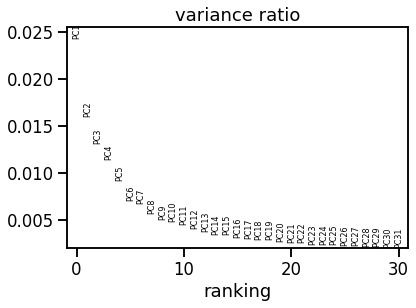

In [190]:
sc.pl.pca_variance_ratio(sample_adata)

In [183]:
sc.pp.neighbors(sample_adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(sample_adata)

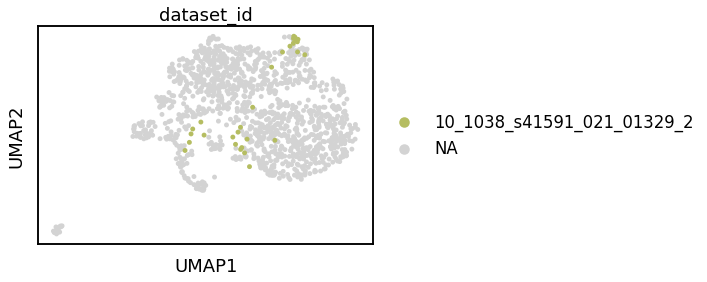

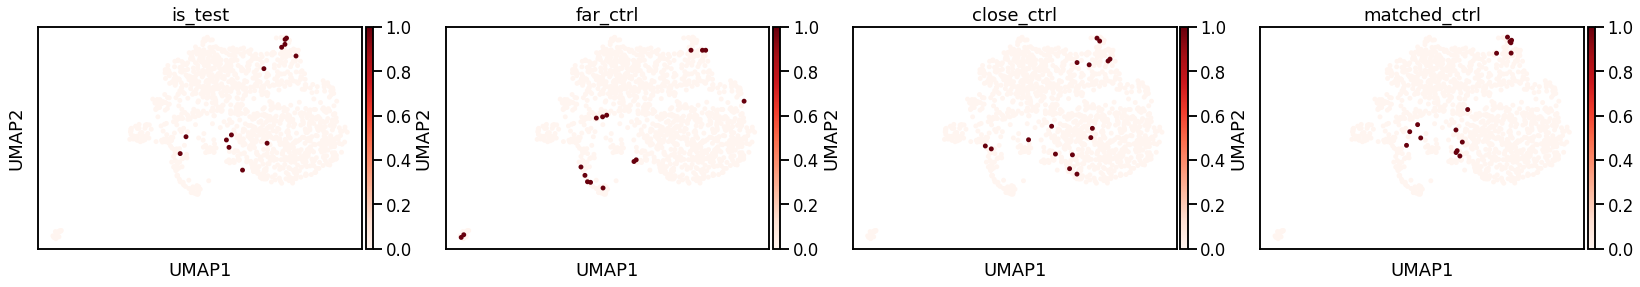

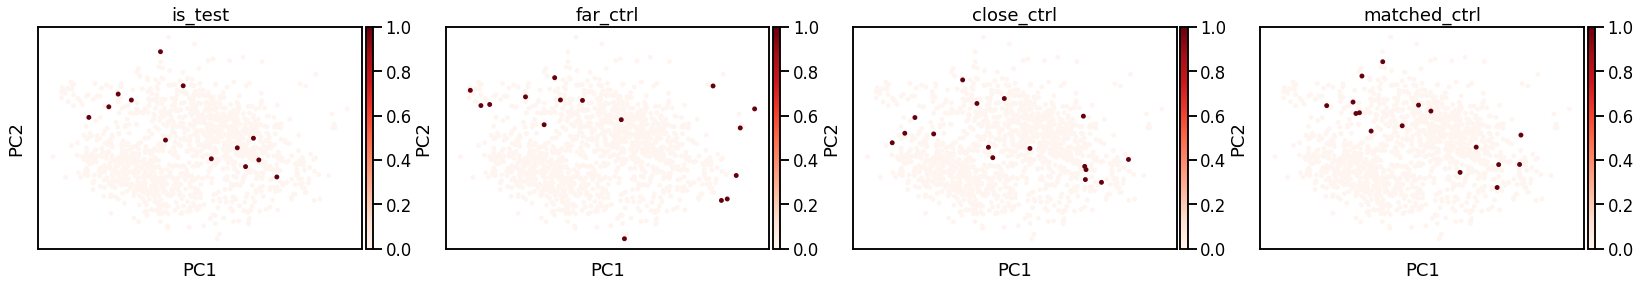

In [191]:
query_dataset = '10_1038_s41591_021_01329_2'
sc.pl.umap(sample_adata, color=['dataset_id'], groups=[query_dataset])
sc.pl.umap(sample_adata, color=['is_test', 'far_ctrl', 'close_ctrl', 'matched_ctrl'], groups=[query_dataset], cmap='Reds')


sc.pl.pca(sample_adata, color=['is_test', 'far_ctrl', 'close_ctrl', 'matched_ctrl'], groups=[query_dataset], cmap='Reds')

### Select controls from PA design
A more realistic scenario: you download an atlas dataset and model, you map the query w scArches, you select close controls, then you perform differential analysis 

In [8]:
def make_sample_adata(adata, keep_obs = ['sex', 'dataset_id', 'ethnicity', 'assay', 'dataset_group']):
    '''
    Make sample x nhood anndata object 

    Params:
    ------
    - adata: anndata object (cell x gene), should contain neighbors
    '''
    
    ## Make nhoods
    milo.make_nhoods(adata, prop=0.01)
    milo.count_nhoods(adata, sample_col='donor_id')
    milopy.utils.add_covariate_to_nhoods_var(adata, keep_obs)
    sample_adata = adata.uns['nhood_adata'].T.copy()
    sample_adata.layers['counts'] = sample_adata.X.copy()

    ## Normalize counts x donor
    sc.pp.normalize_total(sample_adata, target_sum=10000)
    sc.pp.log1p(sample_adata)

    ## Dim reduction
    sc.pp.pca(sample_adata)
    return(sample_adata)

def pick_best_control(
        sample_adata, 
        dataset_group_obs = 'dataset_group', 
        query_level = 'query',
        n_ctrl = None,
        method = 'closest'
        ):
    '''
    Find best donors in atlas cells to use as controls
    '''
    # query_dataset = sample_adata.obs.dataset_id[sample_adata.obs.dataset_group == 'query'][0]
    query_samples = sample_adata.obs_names[sample_adata.obs[dataset_group_obs] == query_level].unique().astype('str')
    sample_adata.obs['is_test'] = sample_adata.obs_names.isin(query_samples).astype('int')
    ctrl_samples_all = sample_adata.obs_names[~sample_adata.obs_names.isin(query_samples)].copy()

    if n_ctrl is None:
        n_ctrl = len(query_samples)

    ## Closest control samples
    closest_ctrl = find_ctrl_samples(sample_adata, ctrl_samples_all, query_samples, method=method, n_ctrl=n_ctrl)
    sample_adata.obs['is_ctrl'] = sample_adata.obs_names.isin(closest_ctrl).astype('int')
    assert sample_adata.obs[['is_test', 'is_ctrl']].sum(1).max() == 1, 'Control and query samples are overlapping'


In [10]:
matched_dirs = [x for x in os.listdir(data_dir) if x.startswith('qPBMC_') and ~x.endswith('.csv')]
for d in matched_dirs:
    pa_adata = sc.read(data_dir + d + "/pa_design.h5ad", backed=True)
    sample_adata = make_sample_adata(pa_adata)
    pick_best_control(sample_adata, method='closest')

    ctrl_comparison_design = sample_adata.obs[['is_test', 'is_ctrl']].copy()
    ctrl_comparison_design.columns = ['is_test', 'close_ctrl']

    ## Add random
    for i in [1,2,3]:
        pick_best_control(sample_adata, method='random')
        ctrl_comparison_design[f'random{i}_ctrl'] = sample_adata.obs['is_ctrl'].copy()

    ## Save ctrl comparison design
    ctrl_comparison_design.to_csv(data_dir + d + '/ctrl_comparison_design.csv')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Run ctrl comparison

In [513]:
conda activate scvi-env
cd /nfs/team205/ed6/bin/diff2atlas/scripts

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/

# p=naive_B_cell
# for p in $(cat /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.txt); do
#     for c in random1 random2 random3 close far; do
#         echo "python run_ctrl_comparison.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${c} ${p} --outpath ${outdir}" | \
#             bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
#     done
# done

# for p in $(cat /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.txt); do
#     for c in matched; do
#         echo "python run_ctrl_comparison.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${c} ${p} --outpath ${outdir}" | \
#             bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
#     done
# done

for d in $(ls -d $outdir/qPBMC*/); do     
    for c in random1 random2 random3 close; do         
        echo "python run_ctrl_comparison.py ${d} ${c}" | bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
    done
done

View of AnnData object with n_obs × n_vars = 16 × 5916
    obs: 'ethnicity', 'sex', 'dataset_id', 'assay', 'donor_id', 'matched_ctrl', 'close_ctrl', 'far_ctrl', 'random1_ctrl', 'random2_ctrl', 'random3_ctrl'
    var: 'index_cell', 'kth_distance'
    uns: 'log1p', 'pca', 'sample_col'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distance_full'

### Load results

In [95]:
def _add_perturb_pop_info(pac_design_adata, perturb_pop,
                            min_perturb_cells = 10, population_obs = 'cell_type'):
    pac_design_adata.obs['is_perturb_pop'] = pac_design_adata.obs[population_obs] == perturb_pop
    perturb_nhoods = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0) > min_perturb_cells
    pac_design_adata.uns['nhood_adata'].obs['is_perturb_nhood'] = perturb_nhoods
    pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells'] = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0)
    pac_design_adata.uns['nhood_adata'].obs['n_cells'] = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()
    pac_design_adata.uns['nhood_adata'].obs['frac_perturb_cells'] = pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells']/pac_design_adata.uns['nhood_adata'].obs['n_cells']

def run_milo(pac_design_adata,
             query_group,
             reference_group,
             sample_col='sample_id',
             annotation_col='cell_type'
             ):
    try:
        milopy.core.make_nhoods(pac_design_adata, prop=0.1)
    except:
        sc.pp.neighbors(pac_design_adata, use_rep='X_scVI')
        milopy.core.make_nhoods(pac_design_adata, prop=0.1)
    milopy.core.count_nhoods(pac_design_adata, sample_col=sample_col)
    milopy.utils.annotate_nhoods(
        pac_design_adata[pac_design_adata.obs['dataset_group'] == reference_group], annotation_col)
    pac_design_adata.obs['is_query'] = pac_design_adata.obs['dataset_group'] == query_group
    milopy.core.DA_nhoods(pac_design_adata, design='~ is_query')
    try:
        milopy.utils.build_nhood_graph(pac_design_adata)
    except:
        sc.pl.umap(sdata)
        milopy.utils.build_nhood_graph(pac_design_adata)

In [96]:
dirs = [x for x in os.listdir(data_dir) if x.startswith('ctrl_comparison_PBMC_500cells') and ~x.endswith('.csv')]
os.listdir(data_dir + '/ctrl_comparison_PBMC_500cells_demo_perturb_cell_typenaive_B_cell_ctrl_far')

['model_fit_ctrl2atlas',
 'model_reference',
 'model_fit_query2atlas',
 'atlas.h5ad',
 'query.h5ad',
 'pac_design.h5ad',
 'ctrl.h5ad']

In [97]:
# def load_ctrl_comparison():
population_obs = 'cell_type' 
dirs = [x for x in os.listdir(data_dir) if x.startswith('ctrl_comparison_PBMC_500cells') and ~x.endswith('.csv')]


In [98]:

nhood_obs_all = pd.DataFrame()
for d in dirs:
    perturb_pop = d.split(population_obs)[1].split('_ctrl')[0]
    ctrl_class = d.split('_ctrl_')[1]
    print(f'Reading {perturb_pop}\n')
    try:
        pac_design_adata = sc.read(data_dir + d + '/pac_design.h5ad', backed=True)
    except:
        continue
    run_milo(pac_design_adata, 'query', 'ctrl', sample_col='donor_id', annotation_col='cell_type')

    ### Define true positive neighbourhoods
    _add_perturb_pop_info(pac_design_adata, perturb_pop)

    ## Store nhood info
    nhood_obs = get_nhood_adata(pac_design_adata).obs.copy()
    nhood_obs['ctrl_class'] = ctrl_class
    nhood_obs['perturb_pop'] = perturb_pop
    nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

Reading mucosal_invariant_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmablast

Reading mucosal_invariant_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading central_memory_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading memory_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmablast

Reading effector_memory_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmacytoid_dendritic_cell

Reading natural_killer_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmacytoid_dendritic_cell

Reading central_memory_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmablast

Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading erythrocyte

Reading erythrocyte

Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading natural_killer_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading mucosal_invariant_T_cell

Reading effector_memory_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading classical_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading central_memory_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading CD14_low_CD16_positive_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading central_memory_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading platelet

Reading platelet

Reading mucosal_invariant_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading erythrocyte

Reading effector_memory_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading classical_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading memory_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmablast

Reading conventional_dendritic_cell

Reading conventional_dendritic_cell

Reading plasmablast

Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading effector_memory_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading CD14_low_CD16_positive_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading erythrocyte

Reading conventional_dendritic_cell

Reading plasmacytoid_dendritic_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading CD14_low_CD16_positive_monocyte

Reading platelet

Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading natural_killer_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmacytoid_dendritic_cell

Reading classical_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading platelet

Reading mucosal_invariant_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading memory_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading platelet

Reading naive_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading memory_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmablast

Reading classical_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading CD14_low_CD16_positive_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading natural_killer_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmacytoid_dendritic_cell

Reading natural_killer_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading natural_killer_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading erythrocyte

Reading platelet

Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading effector_memory_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmacytoid_dendritic_cell

Reading erythrocyte

Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading conventional_dendritic_cell

Reading CD14_low_CD16_positive_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading conventional_dendritic_cell

Reading mucosal_invariant_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading memory_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading central_memory_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading conventional_dendritic_cell

Reading naive_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading CD14_low_CD16_positive_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading memory_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading effector_memory_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading classical_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading classical_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading central_memory_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [27]:
matched_dirs = [x for x in os.listdir(data_dir) if x.startswith('qPBMC_') and ~x.endswith('.csv')]
nhood_obs_matched = pd.DataFrame()
ctrl_class = 'matched'
population_obs = 'cell_type'
for d in matched_dirs:
    perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    pac_design_adata = sc.read(data_dir + d + '/pac_design.h5ad', backed=True)
    # pa_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pa_design.h5ad', backed=True)
    # pc_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pc_design.h5ad', backed=True)
    run_milo(pac_design_adata, 'query', 'ctrl', sample_col='donor_id', annotation_col='cell_type')

    ### Define true positive neighbourhoods
    _add_perturb_pop_info(pac_design_adata, perturb_pop)
    # _add_perturb_pop_info(pa_design_adata)
    # _add_perturb_pop_info(pc_design_adata)


    ## Store nhood info
    # des_dict = {'PAC':pac_design_adata, "PA": pa_design_adata, "PC": pc_design_adata}
    # for design, adata in des_dict.items():
    nhood_obs = get_nhood_adata(pac_design_adata).obs.copy()
    nhood_obs['ctrl_class'] = ctrl_class
    nhood_obs['perturb_pop'] = perturb_pop
    nhood_obs_matched = pd.concat([nhood_obs_matched, nhood_obs])

Reading memory_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading conventional_dendritic_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_B_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading central_memory_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmablast



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading platelet



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading plasmacytoid_dendritic_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading classical_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading erythrocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading natural_killer_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading effector_memory_CD8_positive_alpha_beta_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading mucosal_invariant_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


Reading CD14_low_CD16_positive_monocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


<AxesSubplot:xlabel='logFC', ylabel='frac_perturb_cells'>

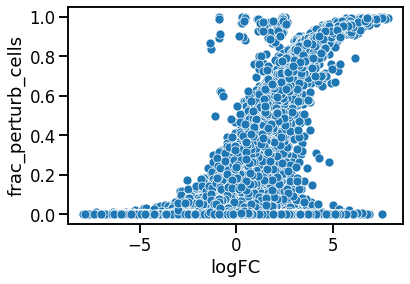

In [38]:
sns.scatterplot(data=nhood_obs_matched, x='logFC', y='frac_perturb_cells')

In [20]:
nhood_obs_all.to_csv(data_dir + 'ctrl_comparison_nhood_obs_all.csv')


NameError: name 'nhood_obs_all' is not defined

In [21]:
nhood_obs_all = pd.read_csv(data_dir + 'ctrl_comparison_nhood_obs_all.csv')

In [22]:
nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs_matched])

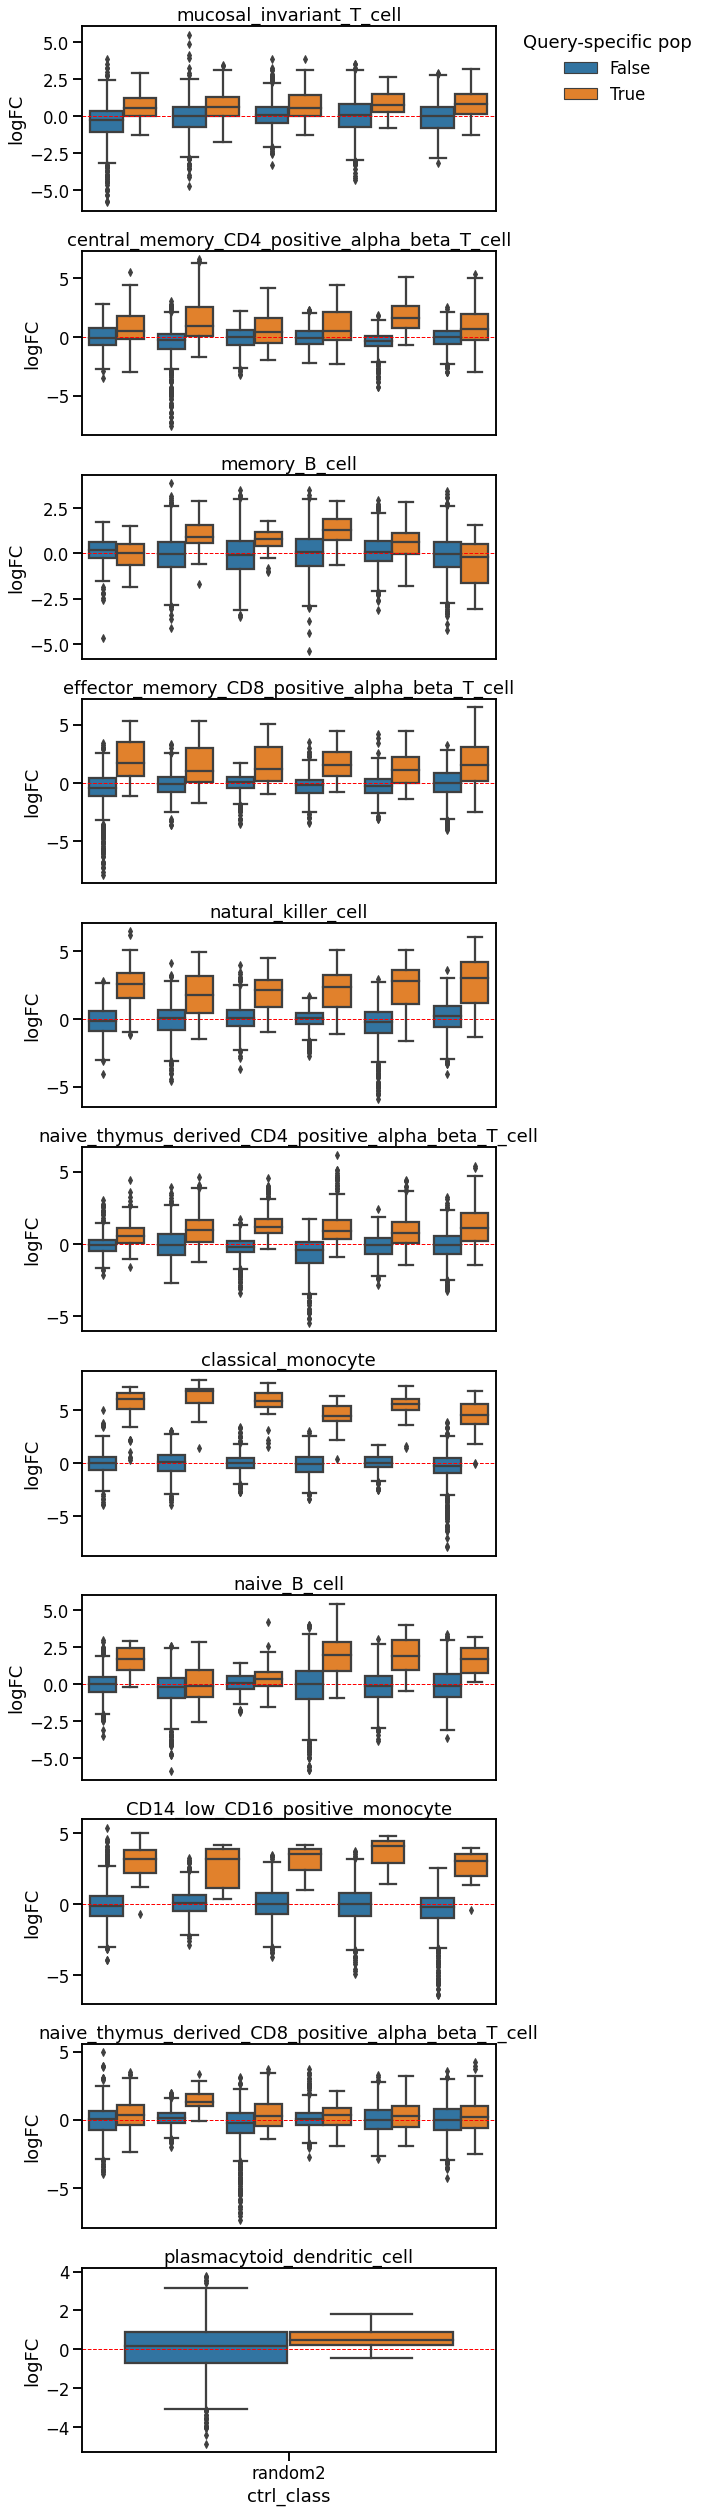

In [99]:
# cts = nhood_obs_all.perturb_pop.unique()
cts = nhood_obs_all.perturb_pop.unique()
with rc_context({'figure.figsize':[10,35]}):
    fig,axs = plt.subplots(len(cts), 1)
    for i, ct in enumerate(cts):
        axs[i].axhline(y=0, color='r', linewidth=1, linestyle='--');
        sns.boxplot(
            data=nhood_obs_all[nhood_obs_all['perturb_pop'] == ct], 
            hue='is_perturb_nhood', y='logFC', x='ctrl_class', ax=axs[i]
        );
        if i == 0:
            axs[i].legend(
                bbox_to_anchor=(1.05, 1), 
                loc='upper left', 
                borderaxespad=0,
                frameon=False,
                title='Query-specific pop');
        else:
            axs[i].legend([],[], frameon=False)
        if i < (len(axs)-1):
            remove_x_axis(axs[i])
        axs[i].set_title(ct)
    fig.tight_layout()

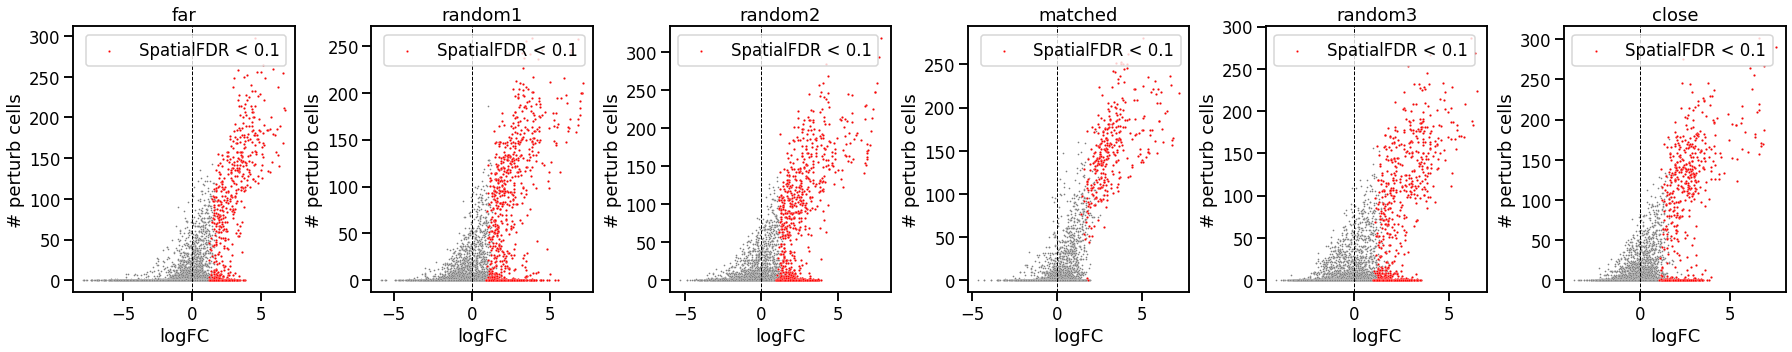

In [100]:
nhood_obs_all['signif_DA'] = (nhood_obs_all.SpatialFDR <= 0.1) & (nhood_obs_all.logFC > 0)
with rc_context({'figure.figsize':[25,5]}):
    for i,d in enumerate(nhood_obs_all.ctrl_class.unique()):
        plt.subplot(1,6,i+1)
        sns.scatterplot(data=nhood_obs_all[nhood_obs_all.ctrl_class==d], x='logFC',  y='n_perturb_cells',  s=3, color='grey');
        sns.scatterplot(data=nhood_obs_all[(nhood_obs_all.ctrl_class==d) & (nhood_obs_all.signif_DA)], x='logFC',  y='n_perturb_cells',  s=5, color='red', label='SpatialFDR < 0.1');
        plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
        plt.title(f'{d}');
        plt.ylabel("# perturb cells");
        plt.tight_layout()

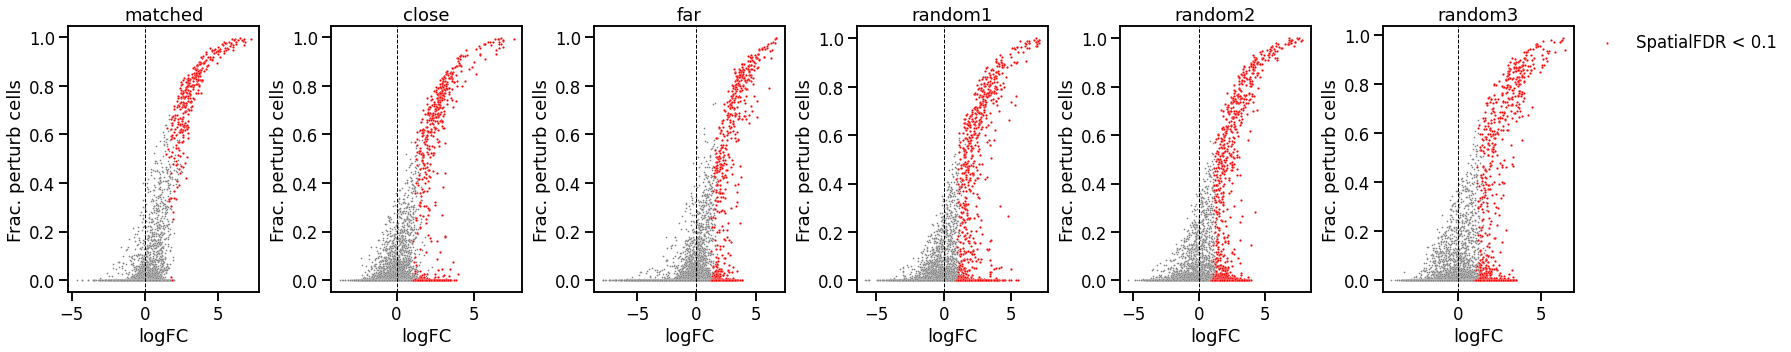

In [151]:
nhood_obs_all['signif_DA'] = (nhood_obs_all.SpatialFDR <= 0.1) & (nhood_obs_all.logFC > 0)
with rc_context({'figure.figsize':[25,5]}):
    for i,d in enumerate(['matched', 'close', 'far','random1', 'random2', 'random3']):
        plt.subplot(1,6,i+1)
        sns.scatterplot(data=nhood_obs_all[nhood_obs_all.ctrl_class==d], x='logFC',  y='frac_perturb_cells',  s=3, color='grey');
        sns.scatterplot(data=nhood_obs_all[(nhood_obs_all.ctrl_class==d) & (nhood_obs_all.signif_DA)], x='logFC',  y='frac_perturb_cells',  s=5, color='red', label='SpatialFDR < 0.1');
        plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
        plt.title(f'{d}');
        plt.ylabel("Frac. perturb cells");
        if i == 5:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False);
        else:
            plt.legend([],[], frameon=False)
        plt.tight_layout()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


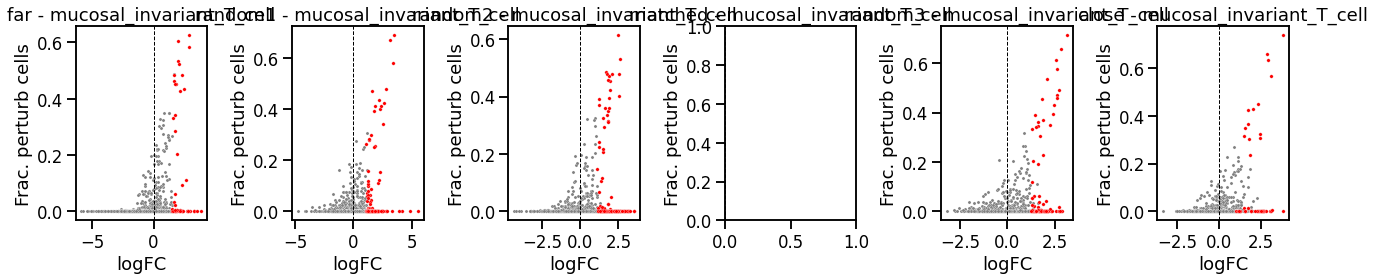

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


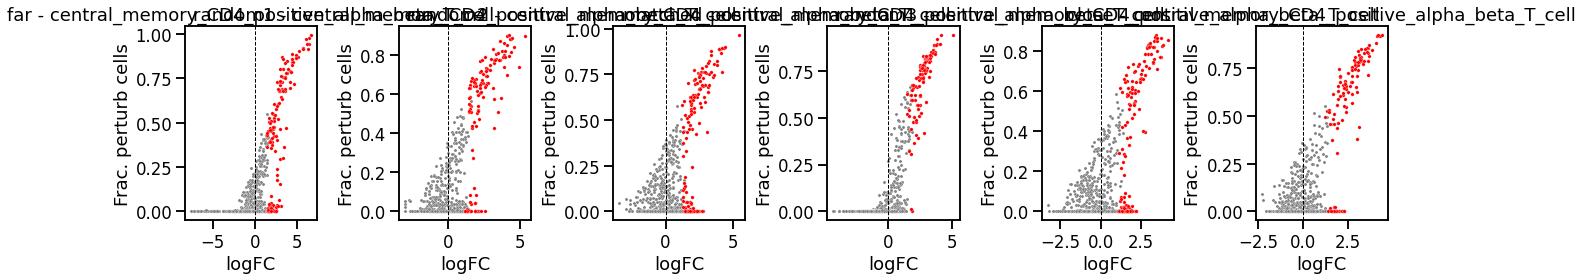

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


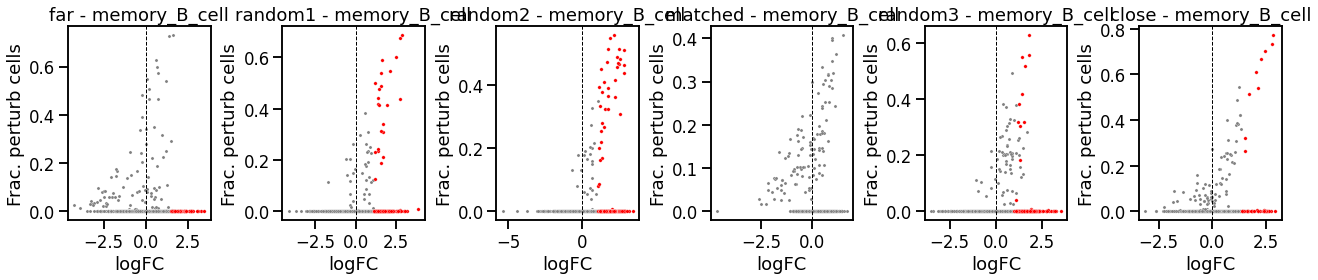

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


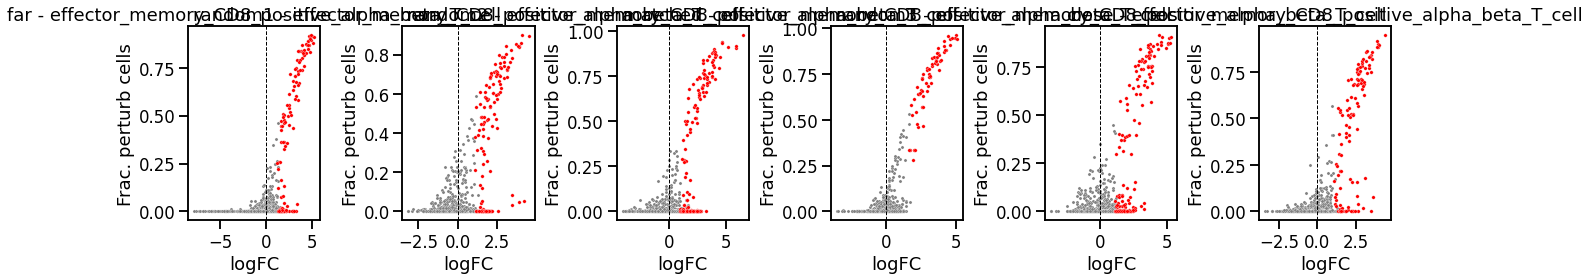

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


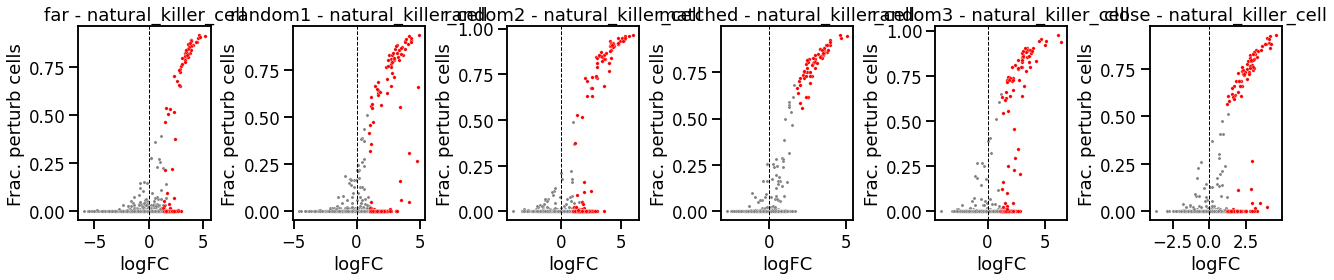

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


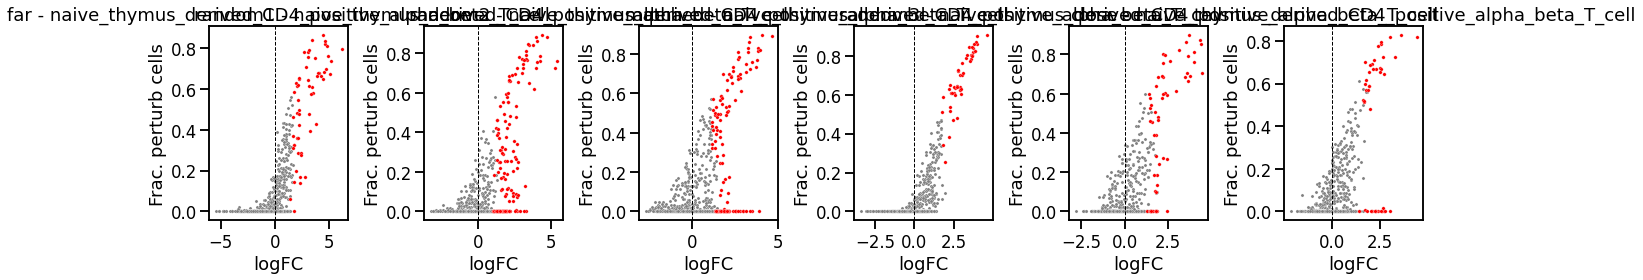

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


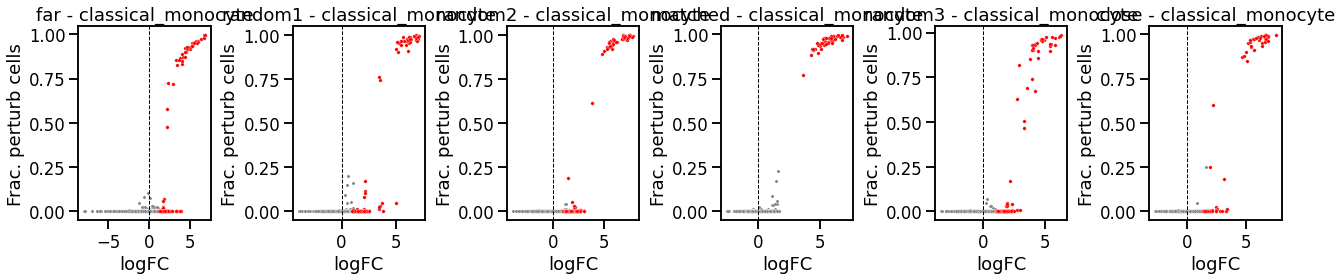

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


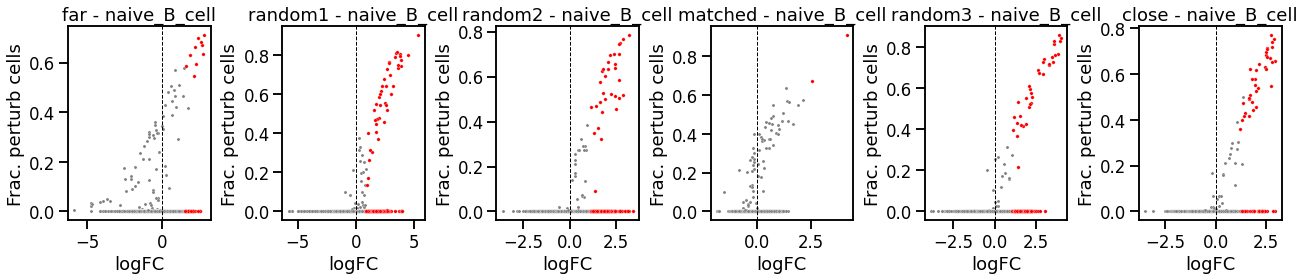

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


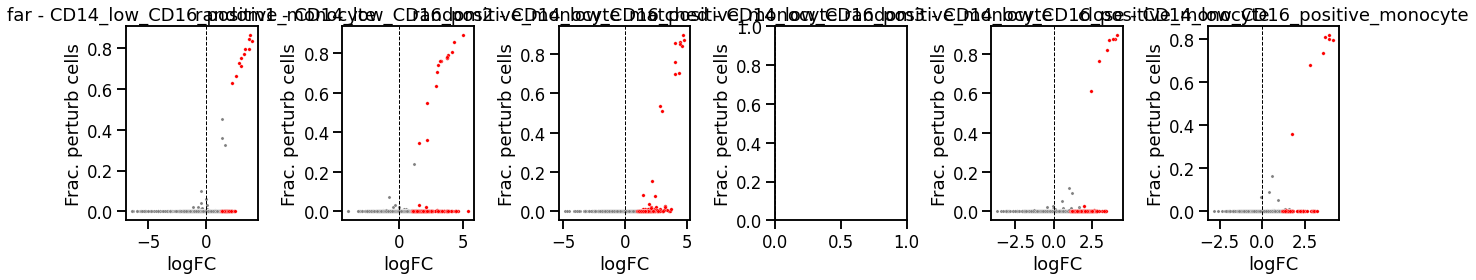

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


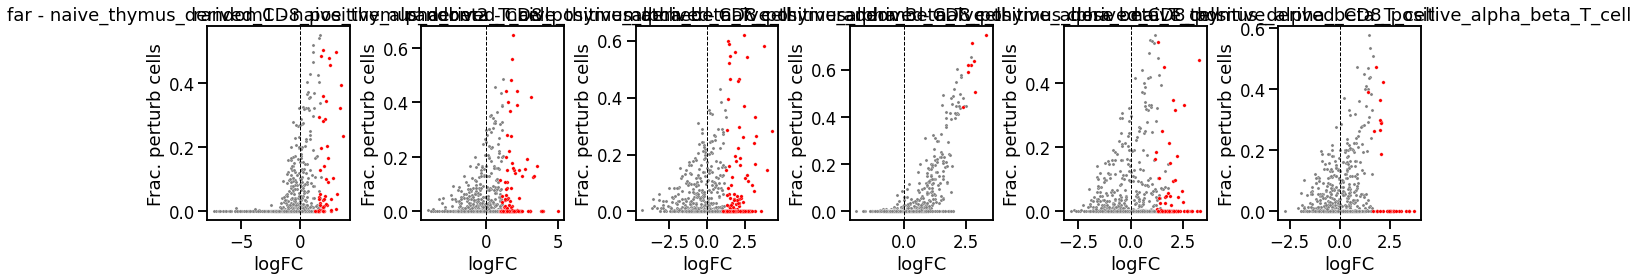

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


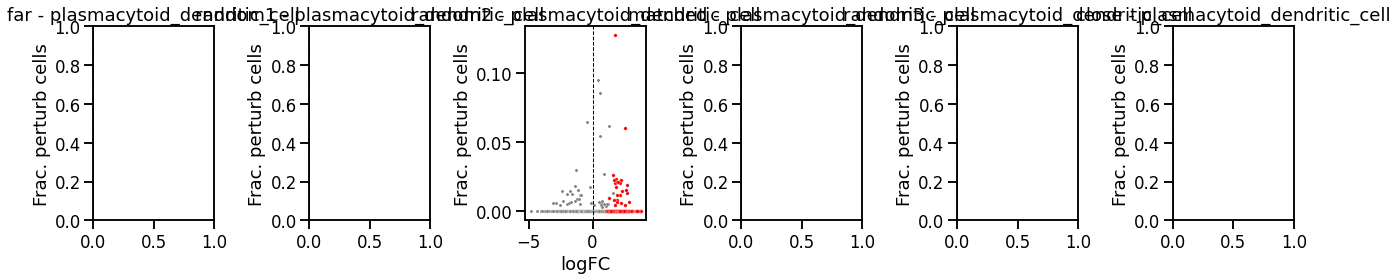

In [103]:
cts = nhood_obs_all.perturb_pop.unique()
for ct in cts:
    nhood_obs = nhood_obs_all[nhood_obs_all.perturb_pop == ct]
    nhood_obs['signif_DA'] = (nhood_obs.SpatialFDR <= 0.1) & (nhood_obs.logFC > 0)
    with rc_context({'figure.figsize':[18,4]}):
        for i,d in enumerate(nhood_obs_all.ctrl_class.unique()):
            plt.subplot(1,6,i+1)
            sns.scatterplot(data=nhood_obs[nhood_obs.ctrl_class==d], x='logFC',  y='frac_perturb_cells',  s=10, color='grey');
            sns.scatterplot(data=nhood_obs[(nhood_obs.ctrl_class==d) & (nhood_obs.signif_DA)], x='logFC',  y='frac_perturb_cells',  s=12, color='red');
            plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
            plt.title(f'{d} - {ct}');
            plt.ylabel("Frac. perturb cells");
            plt.tight_layout();
    # plt.savefig(figdir + f'N_cells_logFC_{ct}.png');
    plt.show()

In [104]:
def _compute_metric_AUROC(out_df_full, metric):
    from sklearn.metrics import roc_curve,auc
    AUROC_df_all = pd.DataFrame()
    for i,c in enumerate(out_df_full['perturb_pop'].unique()):
        out_df = out_df_full[out_df_full['perturb_pop'] == c]
        fpr, tpr, _ = roc_curve(out_df.is_perturb_nhood, out_df[metric])
        AUC  = auc(fpr, tpr)
        AUROC_df = pd.DataFrame(np.vstack([fpr, tpr]), index=['FPR','TPR']).T
        AUROC_df['AUROC'] = AUC
        AUROC_df['perturb_pop'] = c
        AUROC_df_all = pd.concat([AUROC_df_all, AUROC_df])
    AUROC_df_all['metric'] = metric
    return(AUROC_df_all)

AUROC_df_all = pd.DataFrame()
for d in nhood_obs_all.ctrl_class.unique():
    AUROC_df = _compute_metric_AUROC(nhood_obs_all[nhood_obs_all.ctrl_class == d].dropna(), 'logFC')
    AUROC_df['ctrl_class'] = d
    AUROC_df_all = pd.concat([AUROC_df_all, AUROC_df])

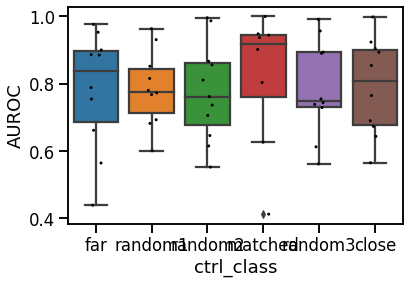

In [108]:
sns.boxplot(data=AUROC_df_all[['AUROC', 'ctrl_class', 'perturb_pop']].drop_duplicates(), x='ctrl_class', y='AUROC');
sns.stripplot(data=AUROC_df_all[['AUROC', 'ctrl_class', 'perturb_pop']].drop_duplicates(), x='ctrl_class', y='AUROC', s=3, color='black');


In [112]:
%%R -i AUROC_df_all
head(AUROC_df_all)

           FPR        TPR     AUROC              perturb_pop metric ctrl_class
1 0.0000000000 0.00000000 0.7542436 mucosal_invariant_T_cell  logFC        far
2 0.0008841733 0.00000000 0.7542436 mucosal_invariant_T_cell  logFC        far
3 0.0044208665 0.00000000 0.7542436 mucosal_invariant_T_cell  logFC        far
4 0.0044208665 0.01980198 0.7542436 mucosal_invariant_T_cell  logFC        far
5 0.0070733864 0.01980198 0.7542436 mucosal_invariant_T_cell  logFC        far
6 0.0070733864 0.03960396 0.7542436 mucosal_invariant_T_cell  logFC        far


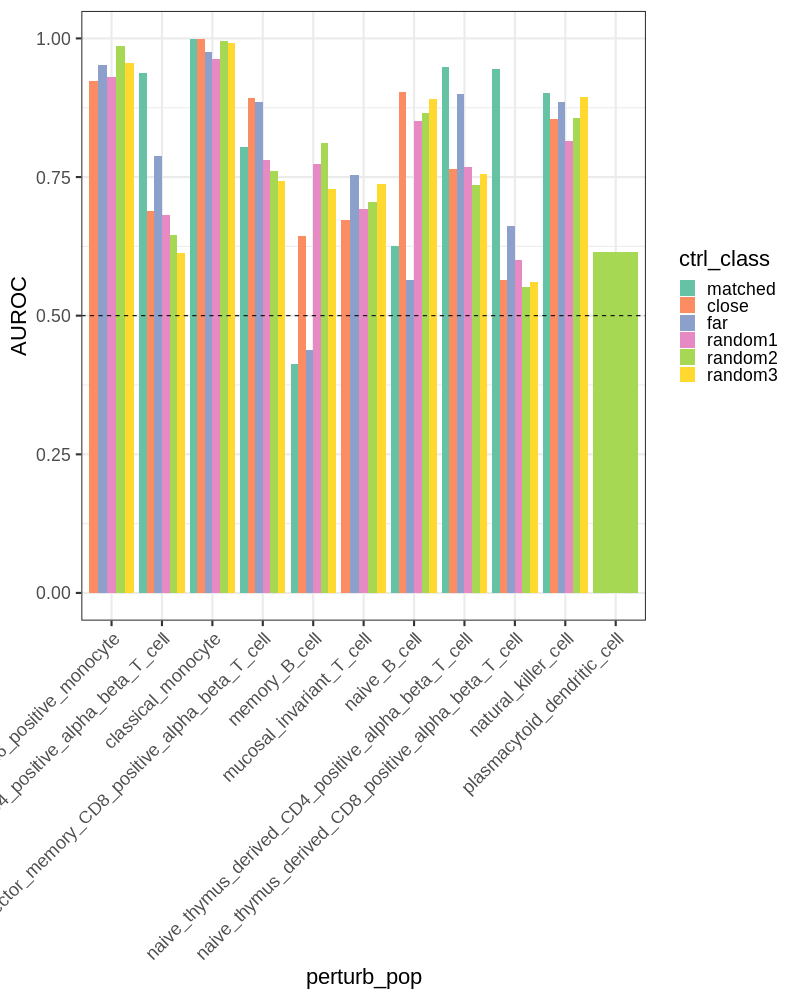

In [149]:
%%R -w 800 -h 1000
AUROC_df_all %>%
    distinct(AUROC, perturb_pop, ctrl_class) %>%
    mutate(ctrl_class = factor(ctrl_class, levels=c("matched", 'close', 'far', 'random1', 'random2', 'random3'))) %>%
    ggplot(aes(perturb_pop, fill=ctrl_class, AUROC)) +
    geom_col(position='dodge') +
    geom_hline(yintercept=0.5, colour='black', linetype='dashed') +
    theme_bw(base_size=22) +
    scale_fill_brewer(palette='Set2') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

#### By significance

In [139]:
cts = nhood_obs_all.perturb_pop.unique()
alpha = 0.1
nhood_obs_all['pred_positive'] = (nhood_obs_all.SpatialFDR < alpha)
nhood_obs_all['TP'] = nhood_obs_all['pred_positive'] & (nhood_obs_all['is_perturb_nhood'])  & (nhood_obs_all.logFC > 0)
nhood_obs_all['FP'] = nhood_obs_all['pred_positive'] & (~nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['FN'] = (~nhood_obs_all['pred_positive']) & (nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['TN'] = (~nhood_obs_all['pred_positive']) & (~nhood_obs_all['is_perturb_nhood'])

In [140]:
tpr_df = nhood_obs_all.groupby(['ctrl_class', 'perturb_pop']).sum()[['TP', 'FP', 'FN', "TN"]].reset_index()
tpr_df['TPR'] = tpr_df['TP'] / (tpr_df['TP'] + tpr_df['FN'])
tpr_df['FPR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TN'])
tpr_df['FDR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TP'])
tpr_df

,ctrl_class,perturb_pop,TP,FP,FN,TN,TPR,FPR,FDR
0,close,CD14_low_CD16_positive_monocyte,7,101,3,889,0.700000,0.102020,0.935185
1,close,central_memory_CD4_positive_alpha_beta_T_cell,90,45,177,502,0.337079,0.082267,0.333333
2,close,classical_monocyte,34,87,1,820,0.971429,0.095921,0.719008
3,close,effector_memory_CD8_positive_alpha_beta_T_cell,93,147,62,594,0.600000,0.198381,0.612500
4,close,memory_B_cell,9,70,53,811,0.145161,0.079455,0.886076
5,close,mucosal_invariant_T_cell,14,93,55,800,0.202899,0.104143,0.869159
6,close,naive_B_cell,35,83,20,819,0.636364,0.092018,0.703390
7,close,naive_thymus_derived_CD4_positive_alpha_beta_T...,29,25,187,654,0.134259,0.036819,0.462963
8,close,naive_thymus_derived_CD8_positive_alpha_beta_T...,10,42,182,751,0.052083,0.052963,0.807692
9,close,natural_killer_cell,65,144,29,669,0.691489,0.177122,0.688995


In [141]:
%%R -i tpr_df
head(tpr_df)

  ctrl_class                                    perturb_pop TP  FP  FN  TN
1      close                CD14_low_CD16_positive_monocyte  7 101   3 889
2      close  central_memory_CD4_positive_alpha_beta_T_cell 90  45 177 502
3      close                             classical_monocyte 34  87   1 820
4      close effector_memory_CD8_positive_alpha_beta_T_cell 93 147  62 594
5      close                                  memory_B_cell  9  70  53 811
6      close                       mucosal_invariant_T_cell 14  93  55 800
        TPR        FPR       FDR
1 0.7000000 0.10202020 0.9351852
2 0.3370787 0.08226691 0.3333333
3 0.9714286 0.09592062 0.7190083
4 0.6000000 0.19838057 0.6125000
5 0.1451613 0.07945516 0.8860759
6 0.2028986 0.10414334 0.8691589


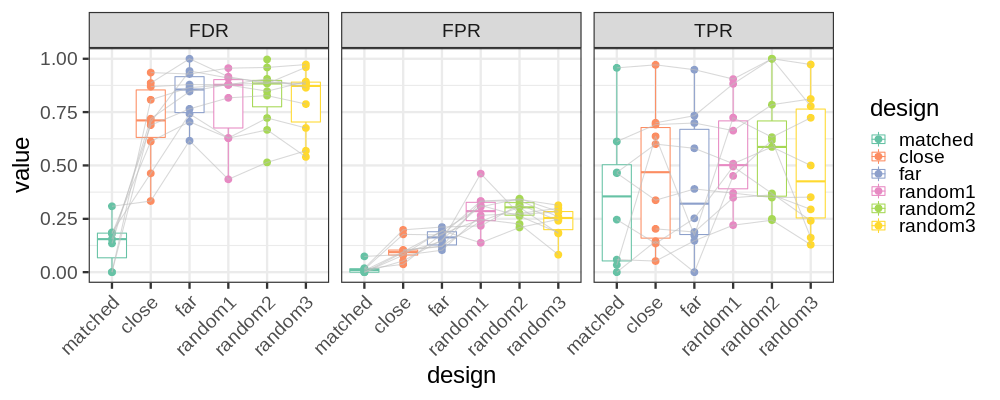

In [145]:
%%R -i tpr_df -w 1000 -h 400
tpr_df %>%
mutate(design = factor(ctrl_class, levels=c("matched", 'close', 'far', 'random1', 'random2', 'random3'))) %>%
pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
ggplot(aes(design, value, color=design)) +
geom_boxplot() +
geom_point(size=3) +
geom_line(aes(group=perturb_pop), color='grey', alpha=0.6) +
facet_wrap(metric~.) +
theme_bw(base_size=24) +
scale_color_brewer(palette='Set2') +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

In [ ]:
nhood_obs_all[nhood_obs_all.ctrl_class == d].dropna()[['ctrl_class', 'perturb_pop']].drop_duplicates()

,ctrl_class,perturb_pop
0,close,plasmacytoid_dendritic_cell
0,close,naive_thymus_derived_CD4_positive_alpha_beta_T...
0,close,naive_B_cell
0,close,central_memory_CD4_positive_alpha_beta_T_cell
0,close,mucosal_invariant_T_cell
0,close,plasmablast
0,close,effector_memory_CD8_positive_alpha_beta_T_cell
0,close,CD14_low_CD16_positive_monocyte
0,close,natural_killer_cell
0,close,classical_monocyte
